In [14]:
import bilby
import matplotlib.pyplot as plt
import corner
import json
#import bayesian as ba
#import plotsettings
import numpy as np
#import compute_credible_intervals as confidence
%matplotlib inline
from scipy.stats import gaussian_kde
from pycbc import types, fft, waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc
import pycbc.psd
from pycbc import transforms
from pycbc  import  detector
import glob
import lal
from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI
from scipy import interpolate
import lalsimulation as lalsim
from scipy.signal import argrelextrema
import os

import pandas as pd

# TPHM 300FS4

In [2]:
duration=8.
sampling_frequency = 512.*2
f_min = 4.4
fRef=4.4
deltaF=1.0/duration
deltaT = 1/sampling_frequency

In [27]:
loc = '/Users/hector/Desktop/GW190521_May21/'
data_L2 = pd.read_table(loc + 'summary_statistics_L2.dat',usecols=['param','maxL'])
data_L3 = pd.read_table(loc + 'summary_statistics_L3.dat',usecols=['param','maxL'])
data_L4 = pd.read_table(loc + 'summary_statistics_L4.dat',usecols=['param','maxL'])
data_L5 = pd.read_table(loc + 'summary_statistics_L5.dat',usecols=['param','maxL']) 

params_L2 = dict(zip(data_L2['param'], data_L2['maxL']))
params_L3 = dict(zip(data_L3['param'], data_L3['maxL']))
params_L4 = dict(zip(data_L4['param'], data_L4['maxL']))
params_L5 = dict(zip(data_L5['param'], data_L5['maxL']))

/opt/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/opt/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.
/opt/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


In [29]:
params_L2

{'h1_cplx_snr_amp': 8.223770183812313,
 'h1_cplx_snr_arg': 0.031456015847356376,
 'h1_optimal_snr': 7.838047739097034,
 'h1_spcal_amp_0': -0.08746407040347323,
 'h1_spcal_amp_1': -0.0021802254785262074,
 'h1_spcal_amp_2': -0.0503183792554204,
 'h1_spcal_amp_3': -0.03839325081838756,
 'h1_spcal_amp_4': 0.0023859950908816114,
 'h1_spcal_amp_5': 0.00871620060621877,
 'h1_spcal_amp_6': 0.01060238686663855,
 'h1_spcal_amp_7': 0.016204073116032367,
 'h1_spcal_amp_8': 0.002486023375948797,
 'h1_spcal_amp_9': 0.004428627978186681,
 'h1_spcal_phase_0': -0.03919177195609727,
 'h1_spcal_phase_1': 0.0076548625715685565,
 'h1_spcal_phase_2': -0.008523291955785937,
 'h1_spcal_phase_3': 0.0054918259331429966,
 'h1_spcal_phase_4': 0.015815674263808727,
 'h1_spcal_phase_5': 0.009406781032410204,
 'h1_spcal_phase_6': -0.005095523512395788,
 'h1_spcal_phase_7': 0.0017000289334256325,
 'h1_spcal_phase_8': 0.005258203295870245,
 'h1_spcal_phase_9': 0.014161769898976913,
 'l1_cplx_snr_amp': 12.6180266963893

In [130]:
case = params_L5

m1_maxl = case['m1']
m2_maxl = case['m2']
phase_maxl = case['phase']
a1_maxl = case['a1']
a2_maxl = case['a2']
theta_jn_maxl = case['theta_jn']
phi_jl_maxl = case['phi_jl']
tilt1_maxl = case['tilt1']
tilt2_maxl = case['tilt2']
phi12_maxl = case['phi12']
dL_maxl = case['dist']
ra_maxl = case['ra']
dec_maxl = case['dec']
pol_maxl = case['psi']
t0_H1_maxl = case['h1_end_time']
t0_L1_maxl = case['l1_end_time']
t0_V1_maxl = case['v1_end_time']

iota_maxl, S1x_maxl, S1y_maxl, S1z_maxl, S2x_maxl, S2y_maxl, S2z_maxl = lalsim.SimInspiralTransformPrecessingNewInitialConditions(
                                                                        theta_jn_maxl,
                                                                         phi_jl_maxl,
                                                                         tilt1_maxl,
                                                                         tilt2_maxl,
                                                                         phi12_maxl,
                                                                         a1_maxl,
                                                                         a2_maxl,
                                                                         m1_maxl*MSUN_SI,
                                                                         m2_maxl*MSUN_SI,
                                                                         fRef,
                                                                         phase_maxl)

In [131]:
approx = lalsim.GetApproximantFromString('IMRPhenomTPHM')

params=lal.CreateDict()
ma=lalsim.SimInspiralCreateModeArray()
lalsim.SimInspiralModeArrayActivateMode(ma, 2, 2)
lalsim.SimInspiralModeArrayActivateMode(ma, 2, -2)
lalsim.SimInspiralModeArrayActivateMode(ma, 2, 1)
lalsim.SimInspiralModeArrayActivateMode(ma, 2, -1)
lalsim.SimInspiralModeArrayActivateMode(ma, 3,3)
lalsim.SimInspiralModeArrayActivateMode(ma, 3,-3)
lalsim.SimInspiralModeArrayActivateMode(ma, 4,4)
lalsim.SimInspiralModeArrayActivateMode(ma, 4,-4)
lalsim.SimInspiralModeArrayActivateMode(ma, 5,5)
lalsim.SimInspiralModeArrayActivateMode(ma, 5,-5)
lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma) 

hpt_maxl, hct_maxl = lalsim.SimInspiralChooseTDWaveform(m1_maxl*MSUN_SI,m2_maxl*MSUN_SI, S1x_maxl, S1y_maxl,
                                            S1z_maxl, S2x_maxl, S2y_maxl, S2z_maxl, dL_maxl*1e6*lal.PC_SI,
                                            iota_maxl, phase_maxl, 0., 0., 0., deltaT, f_min, fRef, params, 
                                            approx)

In [132]:
H, L, V = detector.Detector("H1"), detector.Detector("L1"), detector.Detector("V1")
                
Fp_h1_maxl, Fc_h1_maxl = H.antenna_pattern(ra_maxl, dec_maxl, pol_maxl, t0_H1_maxl)
Fp_l1_maxl, Fc_l1_maxl = L.antenna_pattern(ra_maxl, dec_maxl, pol_maxl, t0_L1_maxl)
Fp_v1_maxl, Fc_v1_maxl = V.antenna_pattern(ra_maxl, dec_maxl, pol_maxl, t0_V1_maxl)

h_H1_maxl = Fp_h1_maxl*hpt_maxl.data.data + Fc_h1_maxl*hct_maxl.data.data
h_L1_maxl = Fp_l1_maxl*hpt_maxl.data.data + Fc_l1_maxl*hct_maxl.data.data
h_V1_maxl = Fp_v1_maxl*hpt_maxl.data.data + Fc_v1_maxl*hct_maxl.data.data

In [133]:
hpt_new = {}
hpt_new[0] = h_H1_maxl
hpt_new[1] = h_L1_maxl
hpt_new[2] = h_V1_maxl

# Align the peak at t=0.
t = {}
tt = np.arange(0, len(hpt_new[1])*deltaT, deltaT)

t[0] = tt_LMAX2 + hpt_maxl.epoch + t0_H1_maxl
t[1] = tt_LMAX2 + hpt_maxl.epoch + t0_L1_maxl
t[2] = tt_LMAX2 + hpt_maxl.epoch + t0_V1_maxl

t0s = {}
t0s[0] = t0_H1_maxl - 1242442967
t0s[1] = t0_L1_maxl - 1242442967
t0s[2] = t0_V1_maxl - 1242442967

t0s_L5 = t0s.copy()

In [118]:
psdL1dir = "/Users/hector/Desktop/psd-fix-data/glitch_median_PSD_forLI_L1.dat"
psdH1dir = "/Users/hector/Desktop/psd-fix-data/glitch_median_PSD_forLI_H1.dat"
psdV1dir = "/Users/hector/Desktop/psd-fix-data/glitch_median_PSD_forLI_V1.dat"

psds = [psdH1dir,psdL1dir,psdV1dir]

In [134]:
whitened_L5 = {}
for idx in [0,1,2]:
    hpycbc = pycbc.types.timeseries.TimeSeries(hpt_new[idx],delta_t=hpt_maxl.deltaT,epoch=hpt_maxl.epoch)
    template = hpycbc.cyclic_time_shift(hpycbc.start_time)
    tapered = template.highpass_fir(30, 120, remove_corrupted=False)
    tapered_fd = hpycbc.to_frequencyseries()
    freqspsd, psd = np.loadtxt(psds[idx],unpack=True)
    ipsd = interpolate.interp1d(freqspsd,psd)
    white_template = (tapered_fd[:-2]/ ipsd(tapered_fd.sample_frequencies[:-2])**0.5*tapered_fd.delta_f).to_timeseries()
    white_template = white_template.highpass_fir(30, 120).lowpass_fir(100, 512)
    whitened_L5[idx] = white_template

# Check cWB and whitened data

In [97]:
from gwpy.timeseries import TimeSeries

event = "GW190521"
trigtime=1242442967.447
f_range=(9, 400)
q_range=(6,6)
searchwin=0.1
outseg=(-4+trigtime,4+trigtime)
delta_t=1./1024
times = np.arange(outseg[0],outseg[1],delta_t)

dets=["H1","L1","V1"]
det_names = ['Hanford','Livingston','Virgo']

In [98]:
# Taken from https://dcc.ligo.org/LIGO-P2000158/public
dir_fig1_data = '/Users/hector/Downloads/GW190521_discovery_Fig1/'

cwb_data   = [np.genfromtxt(dir_fig1_data+"{}_pewave_cr.txt".format(det), names=True) for det in dets]
white_data = [np.genfromtxt(dir_fig1_data+"whitened_data_{}.dat".format(det)) for det in dets]

white_data = [TimeSeries(data=wd, dt=delta_t, t0=times[0]) for w,wd in enumerate(white_data)]

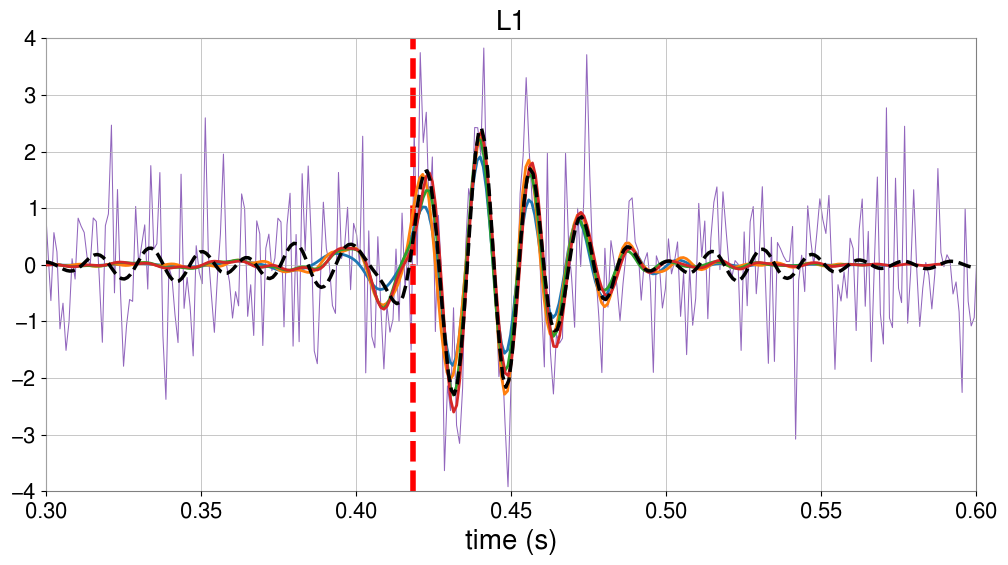

In [158]:
detname = ['H1','L1','V1']

cb_friendly_list = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

li_color=cb_friendly_list[12]
bw_color=cb_friendly_list[5]
cwb_color=cb_friendly_list[0]
nanosecond=np.mod(1242442967.44726562,1)
origin=1242442967 #(Ratio to multiply the "strain" data with so that it's units of single digit numbers)

col = 1

plt.figure(figsize=(12,6),dpi=100)
plt.plot(np.array(white_data[col].xindex)-origin , white_data[col],
                                        lw=0.75,alpha=0.6, color=bw_color, zorder=1 , label='Whitened data')
plt.plot(cwb_data[col]['time']-origin, cwb_data[col]['amp_cwb_rec'],
                                        lw=2.5, color=cwb_color, zorder=4 , label='cWB reconstruction',linestyle='dashed')
plt.plot(whitened_L2[col].sample_times+t0s_L2[col], 1/(2*np.pi)*whitened_L2[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq2$')
plt.plot(whitened_L3[col].sample_times+t0s_L3[col], 1/(2*np.pi)*whitened_L3[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq3$')
plt.plot(whitened_L4[col].sample_times+t0s_L4[col], 1/(2*np.pi)*whitened_L4[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq4$')
plt.plot(whitened_L5[col].sample_times+t0s_L5[col], 1/(2*np.pi)*whitened_L5[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq5$')
plt.xlim(0.3, 0.6)
plt.ylim(-4,4)
plt.xlabel('time (s)',fontsize=20)
#plt.legend(prop={'size': 10})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(t0s[col],color='red',linestyle='dashed',linewidth=4)
plt.title(detname[col],fontsize=20)
#plt.xlabel('t(s) - {0} GPS'.format(origin))
plt.show()

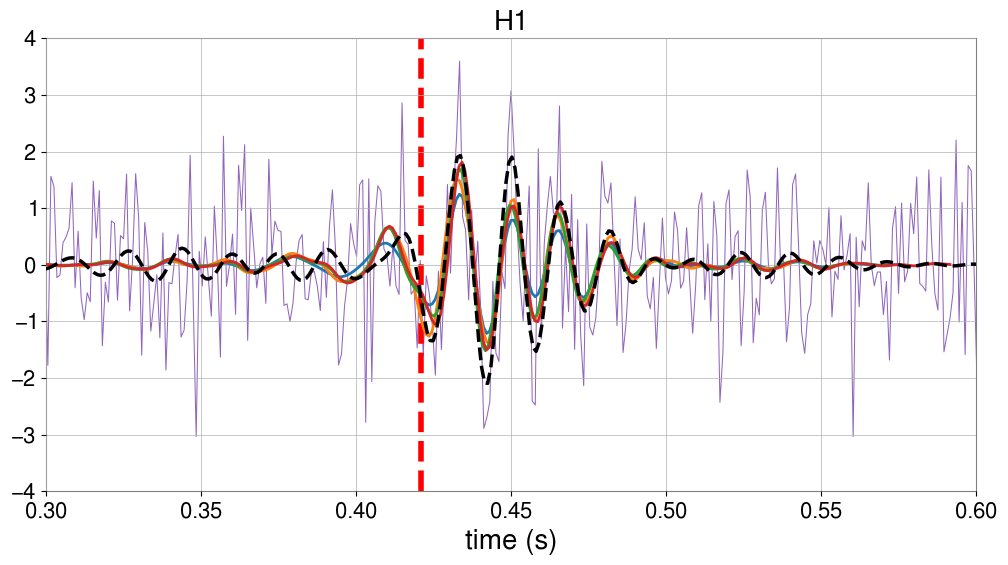

In [157]:
detname = ['H1','L1','V1']

cb_friendly_list = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

li_color=cb_friendly_list[12]
bw_color=cb_friendly_list[5]
cwb_color=cb_friendly_list[0]
nanosecond=np.mod(1242442967.44726562,1)
origin=1242442967 #(Ratio to multiply the "strain" data with so that it's units of single digit numbers)

col = 0

plt.figure(figsize=(12,6),dpi=100)
plt.plot(np.array(white_data[col].xindex)-origin , white_data[col],
                                        lw=0.75,alpha=0.6, color=bw_color, zorder=1 , label='Whitened data')
plt.plot(cwb_data[col]['time']-origin, cwb_data[col]['amp_cwb_rec'],
                                        lw=2.5, color=cwb_color, zorder=4 , label='cWB reconstruction',linestyle='dashed')
plt.plot(whitened_L2[col].sample_times+t0s_L2[col], 1/(2*np.pi)*whitened_L2[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq2$')
plt.plot(whitened_L3[col].sample_times+t0s_L3[col], 1/(2*np.pi)*whitened_L3[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq3$')
plt.plot(whitened_L4[col].sample_times+t0s_L4[col], 1/(2*np.pi)*whitened_L4[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq4$')
plt.plot(whitened_L5[col].sample_times+t0s_L5[col], 1/(2*np.pi)*whitened_L5[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq5$')
plt.xlim(0.3, 0.6)
plt.ylim(-4,4)
plt.xlabel('time (s)',fontsize=20)
#plt.legend(prop={'size': 10})
plt.axvline(t0s[col],color='red',linestyle='dashed',linewidth=4)
plt.title(detname[col],fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlabel('t(s) - {0} GPS'.format(origin))
plt.show()

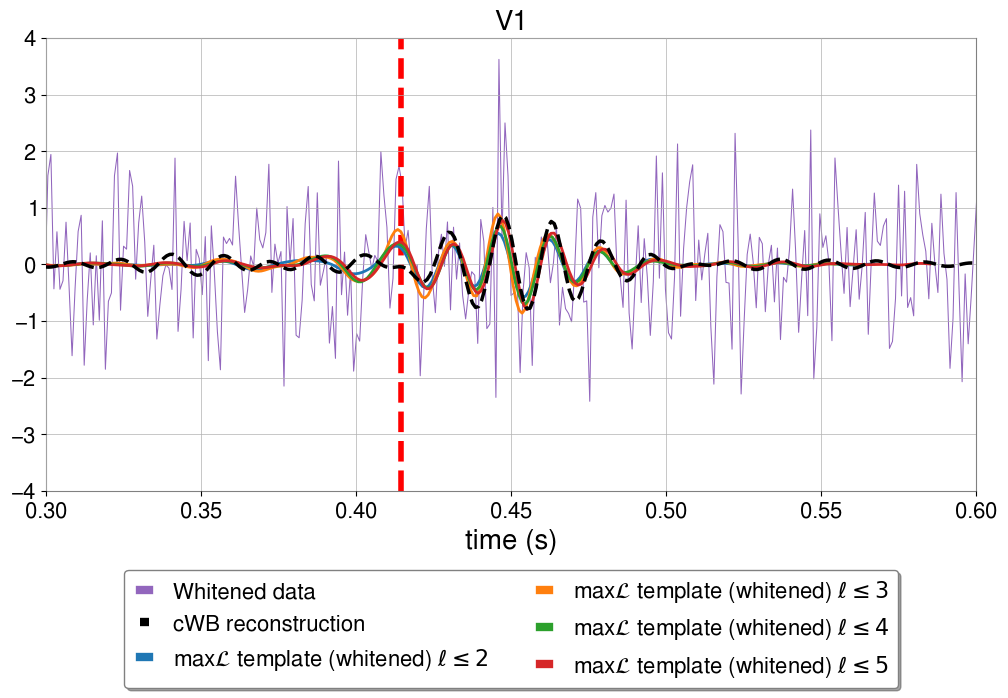

In [156]:
detname = ['H1','L1','V1']

cb_friendly_list = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

li_color=cb_friendly_list[12]
bw_color=cb_friendly_list[5]
cwb_color=cb_friendly_list[0]
nanosecond=np.mod(1242442967.44726562,1)
origin=1242442967 #(Ratio to multiply the "strain" data with so that it's units of single digit numbers)

col = 2

plt.figure(figsize=(12,6),dpi=100)
plt.plot(np.array(white_data[col].xindex)-origin , white_data[col],
                                        lw=0.75,alpha=0.6, color=bw_color, zorder=1 , label='Whitened data')
plt.plot(cwb_data[col]['time']-origin, cwb_data[col]['amp_cwb_rec'],
                                        lw=2.5, color=cwb_color, zorder=4 , label='cWB reconstruction',linestyle='dashed')
plt.plot(whitened_L2[col].sample_times+t0s_L2[col], 1/(2*np.pi)*whitened_L2[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq2$')
plt.plot(whitened_L3[col].sample_times+t0s_L3[col], 1/(2*np.pi)*whitened_L3[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq3$')
plt.plot(whitened_L4[col].sample_times+t0s_L4[col], 1/(2*np.pi)*whitened_L4[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq4$')
plt.plot(whitened_L5[col].sample_times+t0s_L5[col], 1/(2*np.pi)*whitened_L5[col], lw=2,zorder=3, label='max$\mathcal{L}$ template (whitened) $\ell\leq5$')
plt.xlim(0.3, 0.6)
plt.ylim(-4,4)
plt.xlabel('time (s)',fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2, fontsize=16)
plt.axvline(t0s[col],color='red',linestyle='dashed',linewidth=4)
plt.title(detname[col],fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlabel('t(s) - {0} GPS'.format(origin))
plt.show()